In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
import os
import sys
import copy
import json
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, os.path.join(root, 'simclr'))
import metrics
import model as model_lib
from utils import get_files_and_labels, get_tf_dataset, read_class_label_map

from absl import logging
logging.set_verbosity(logging.ERROR)

# Define core eval logic

In [4]:
def perform_evaluation(model, ds, num_classes, ckpt, model_dir, strategy=None, eval_steps=1, batch_size=256):
    """Evaluates the given model at a given checkpoint on the provided (test) data set."""
    
    summary_writer = tf.summary.create_file_writer(model_dir)
    
    # Build metrics
    # TODO: Use scopes
    supervised_loss = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True, name='eval/supervised_loss')
    label_top_1_accuracy = tf.keras.metrics.Accuracy('eval/label_top_1_accuracy')
    label_top_5_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(5, 'eval/label_top_5_accuracy')
    all_metrics = [supervised_loss, label_top_1_accuracy, label_top_5_accuracy]

    # Restore checkpoint
    print(f"Restoring from {ckpt}")
    checkpoint = tf.train.Checkpoint(model=model, global_step=tf.Variable(0, dtype=tf.int64))
    status = checkpoint.restore(ckpt).expect_partial()
    global_step = checkpoint.global_step
    print(f"Performing eval at step {global_step.numpy()}")
    
    # Compile model
    model.compile(
        metrics=all_metrics
    )
    
    def eval_step(X, y):
        """Makes predictions on images and updates metrics"""
        labels = y #tf.one_hot(y, num_classes)
        _, supervised_head_outputs = model(X, training=False)
        assert supervised_head_outputs is not None
        logits = supervised_head_outputs
        metrics.update_finetune_metrics_eval(
            label_top_1_accuracy,
            label_top_5_accuracy,
            logits,
            labels
        )
        supervised_loss.update_state(labels, logits)
        return logits, labels
        
    logits = []
    labels = []
    temp_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    for it, (X, y) in enumerate(iter(temp_ds)):
        logits_, labels_ = eval_step(X, y)
        logits.append(logits_.numpy())
        labels.append(labels_)
    logits = np.concatenate(logits)
    labels = np.concatenate(labels)
    predictions = np.argmax(logits, axis=1)
    
    # Write summaries
    result_json_path = os.path.join(model_dir, 'result.json')
    result = {metric.name: metric.result().numpy() for metric in all_metrics}
    result['global_step'] = global_step.numpy()
    print(result)
    with tf.io.gfile.GFile(result_json_path, 'w') as f:
        json.dump({k: float(v) for k, v in result.items()}, f)

    return logits, predictions, labels

# Prepare (test) dataset

Set up the appropriate directories and use helper functions in `simclr.utils` to generate a TensorFlow Dataset

In [5]:
root = os.path.dirname(os.path.abspath(''))  # simclr-experiments folder
data_dir = os.path.join(root, 'data/hirise-map-proj-v3_2')
img_folder = os.path.join(data_dir, 'map-proj-v3_2')
file_list = os.path.join(data_dir, 'test-set-v3.2.txt')
class_mapping = read_class_label_map(os.path.join(
    data_dir, 'landmarks_map-proj-v3_2_classmap.csv'))

X, num_files, num_classes, class_mapping = get_files_and_labels(
    img_folder, ext="jpg", metadata_file=file_list, mapping=class_mapping
)

image_size = 227
test_ds = get_tf_dataset(
    X, "jpg", preprocess=True, width=image_size, height=image_size)

# Define plotting functions

Note that this needs to happen after `read_class_label_map` defines the `class_mapping` dict.

In [6]:
classes = list(class_mapping.keys())


def plot_confusion_matrix(y_true, y_pred, ckpt, dataset=None):
    fig, ax = plt.subplots(figsize=(6, 5))

    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=classes)
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    accuracy = sklearn.metrics.accuracy_score(
        y_true, y_pred, sample_weight=None)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'

    sns.heatmap(cm, annot=True, cmap='viridis', fmt='.0f')
    ax.set_title(
        f"Finetuned on full training data (2900 images) - overall accuracy: {100*accuracy:.2f}%")

    plt.tight_layout()
    plt.savefig(f"{ckpt}_test.png", transparent=True, bbox_inches='tight')
    plt.show()
    return fig, ax, cm, accuracy


def set_font_size(ax, fontsize=12):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)


def plot_precision_vs_recall(y_true, y_pred, ckpt):
    fig, ax = plt.subplots(figsize=(8, 6))

    cr = sklearn.metrics.classification_report(
        y_true, y_pred, labels=classes, output_dict=True)
    cr_df = pd.DataFrame.from_dict(cr).T

    # add "num_samples" column to classification report - should be equivalent to "Support" column
    num_examples = pd.DataFrame(
        pd.DataFrame(
            [classes[x[1]] for x in X],
            columns=['class']).value_counts(),
        columns=['num_samples']
    ).reset_index()    
    cr_df_with_counts = pd.merge(num_examples, cr_df.reset_index().rename(
        columns={'index': 'class'}), how='inner')

    mean_precision = cr_df.loc['macro avg', 'precision']
    mean_recall = cr_df.loc['macro avg', 'recall']
    mean_f1 = cr_df.loc['macro avg', 'f1-score']

    class_order = [
        'other', 'crater', 'dark dune', 'slope streak', 'bright dune', 'impact ejecta', 'swiss cheese', 'spider'
    ]
    marker_order = [
        "*", "v", "s", "o", "s", "X", "d", "^"
    ]
    kiri_markers = {c: m for c, m in zip(class_order, marker_order)}
    colors = list(plt.get_cmap('tab20').colors)
    colors = [colors[i] for i in [0, 2, 5, 8, 11, 15, 17, 19]]
#     colors.pop(class_order.index('Night sky'))

    cr_df_with_counts = cr_df_with_counts.sort_values(
        by='class', key=lambda x: [class_order.index(xx) for xx in x])
    for i in range(0, len(cr_df_with_counts)):
        x = cr_df_with_counts.iat[i, 3]  # recall
        y = cr_df_with_counts.iat[i, 2]  # precision
        cls = cr_df_with_counts.iat[i, 0]  # class
        n_min, n_max = cr_df_with_counts['num_samples'].min(
        ), cr_df_with_counts['num_samples'].max()
        s = 95
        alpha = 0.5 if np.isclose(x, 0) and np.isclose(y, 0) else 1
        label = cls + ' (at [0, 0])' if np.isclose(x,
                                                   0) and np.isclose(y, 0) else cls
        ax.scatter(x, y, s=s, c=[colors[i]],
                   marker=kiri_markers[cls], label=label, alpha=alpha)

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_xlim((-0.04, 1.04))
    ax.set_ylim((-0.04, 1.04))
    plt.grid(linestyle='--')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    set_font_size(ax, 14)
    plt.tight_layout()
    ax.set_aspect(1.)
    ax.text(
        x=0.65,
        y=0.05,
        s=(f"Mean precision: {mean_precision*100:.2f} %\n"
           f"Mean recall: {mean_recall*100:.2f} %\n"
           f"Mean F1: {mean_f1*100:.2f} %")
    )

    plt.savefig(f"{ckpt}_precision_recall_test.png", transparent=True, bbox_inches='tight')
    plt.show()
    return fig, ax, cr_df_with_counts, mean_precision, mean_recall

# Create model instance and set up checkpoint paths

Must update everything so that model params match those used in `model_dir/model_str/config.json`

In [7]:
resnet_depth = 50
width_multiplier = 2
sk_ratio = 0.0625
num_proj_layers = 3
proj_out_dim = 128
model_dir = '/home/goh/Documents/D3M/mars_simclr_models'
dataset = 'hirise-10pct'

# Set up checkpoint directory
timestamp = '2021-08-10_0943'
model_substr = f"r{resnet_depth}_{width_multiplier}x_sk{int(sk_ratio > 0)}"
model_str = f"finetune_{dataset}_{model_substr}_proj{proj_out_dim}_{num_proj_layers}projLayers"
log_name = f"{model_str}_{timestamp}"
checkpoint = f'/home/goh/Documents/D3M/simclr_tf2_models/pretrained/{model_substr}/saved_model'
model_dir = os.path.join(model_dir, log_name)
print(
    f"model_substr = {model_substr}\n"
    f"model_str = {model_str}\n"
    f"model_dir = {model_dir}\n"
    f"log_name = {log_name}\n"
    f"checkpoint = {checkpoint}"
)
with tf.device('/gpu:7'):
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3', '/gpu:4', '/gpu:5', '/gpu:6', '/gpu:7'])
# with strategy.scope():
    model = model_lib.Model(
        num_classes,
        image_size,
        train_mode="finetune",
        optimizer_name="lars",
        weight_decay=0,
        resnet_depth=resnet_depth,
        sk_ratio=sk_ratio,
        width_multiplier=width_multiplier,
        proj_out_dim=proj_out_dim,
        num_proj_layers=num_proj_layers,
        ft_proj_selector=0,
        head_mode="nonlinear",
        fine_tune_after_block=-1,
        linear_eval_while_pretraining=False,
    )

    model.build((None, image_size, image_size, 3))
    model.summary()

model_substr = r50_2x_sk1
model_str = finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers
model_dir = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943
log_name = finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943
checkpoint = /home/goh/Documents/D3M/simclr_tf2_models/pretrained/r50_2x_sk1/saved_model
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet (Resnet)              multiple                  140428864 
_________________________________________________________________
projection_head (ProjectionH multiple                  34111872  
_________________________________________________________________
head_supervised (SupervisedH multiple                  32776     
Total params: 174,573,512
Trainable params: 174,434,056
Non-trainable params: 139,456
_____________________________________________________

# # Evaluate each checkpoint saved in `model_dir`

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-17
Performing eval at step 0
{'eval/supervised_loss': 0.43714398, 'eval/label_top_1_accuracy': 0.91243726, 'eval/label_top_5_accuracy': 0.9927496, 'global_step': 0}


<IPython.core.display.Javascript object>


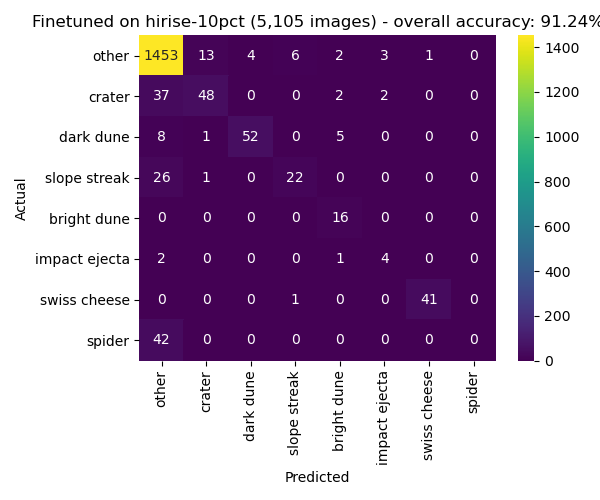

<IPython.core.display.Javascript object>


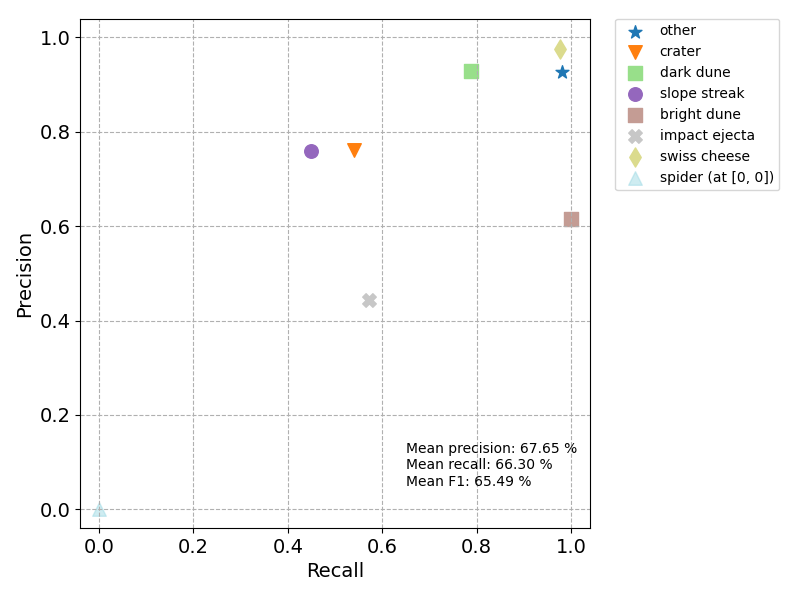

/home/goh/anaconda3/envs/d3m_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-17
 acc = 91.24
 mean_precision = 67.65
mean_recall = 66.30

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-18
Performing eval at step 0
{'eval/supervised_loss': 0.45278406, 'eval/label_top_1_accuracy': 0.91243726, 'eval/label_top_5_accuracy': 0.98940325, 'global_step': 0}


<IPython.core.display.Javascript object>


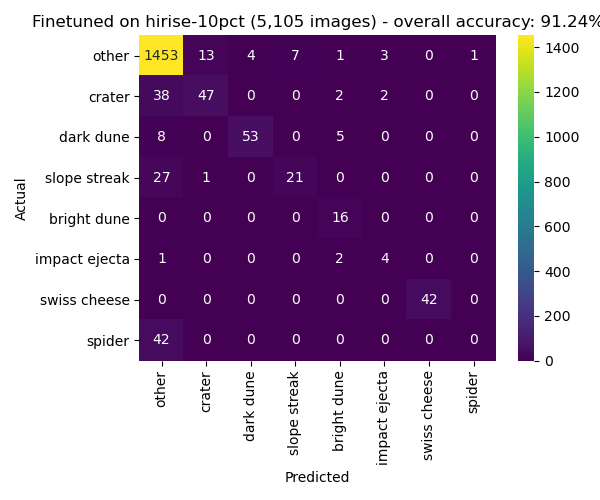

<IPython.core.display.Javascript object>


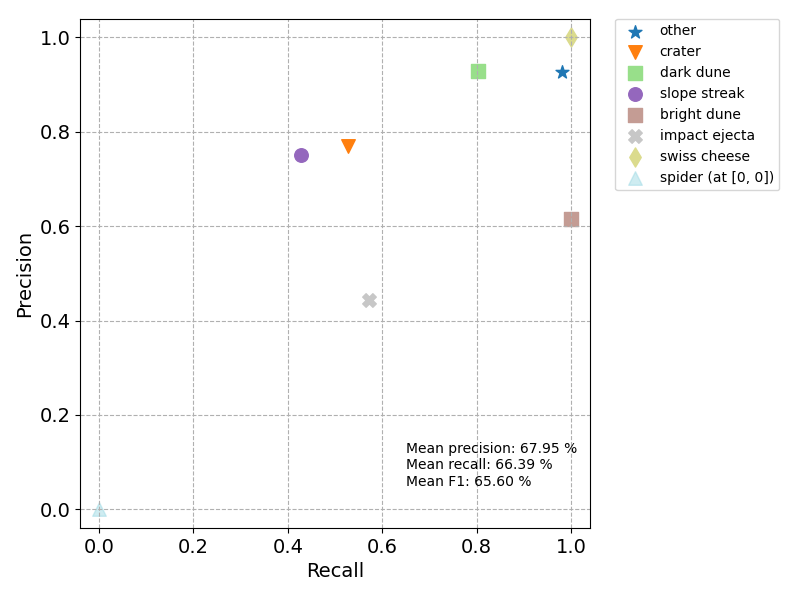

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-18
 acc = 91.24
 mean_precision = 67.95
mean_recall = 66.39

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-19
Performing eval at step 0
{'eval/supervised_loss': 0.46466833, 'eval/label_top_1_accuracy': 0.9141104, 'eval/label_top_5_accuracy': 0.98996097, 'global_step': 0}


<IPython.core.display.Javascript object>


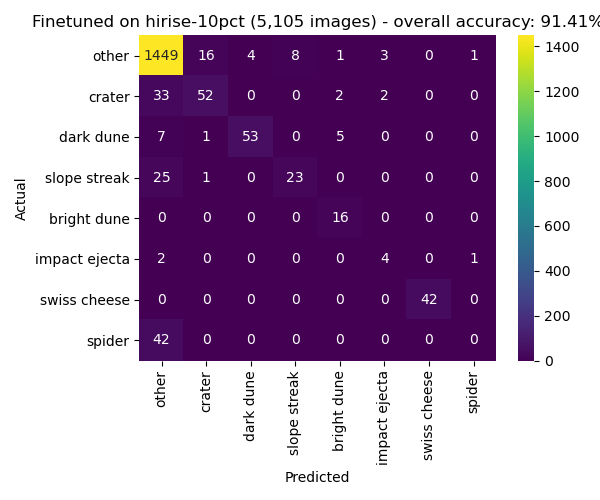

<IPython.core.display.Javascript object>


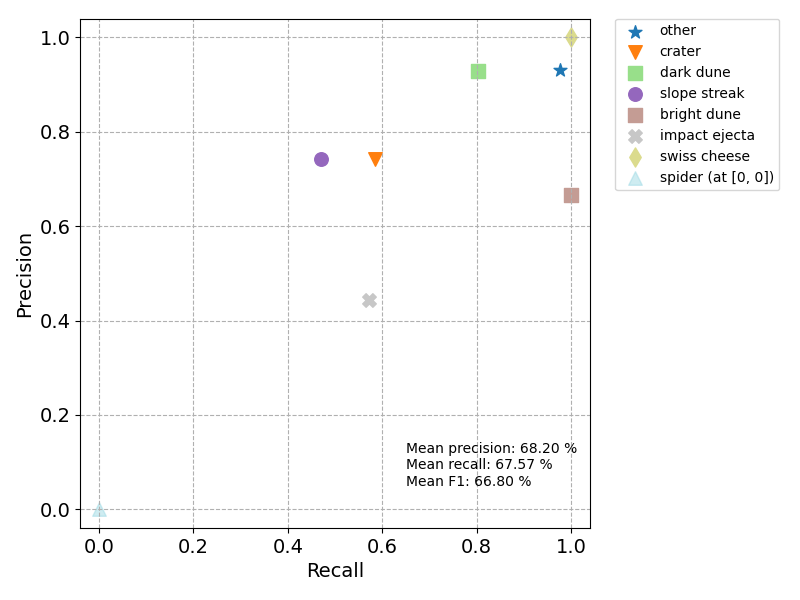

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-19
 acc = 91.41
 mean_precision = 68.20
mean_recall = 67.57

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-20
Performing eval at step 0
{'eval/supervised_loss': 0.51232976, 'eval/label_top_1_accuracy': 0.9113218, 'eval/label_top_5_accuracy': 0.9905187, 'global_step': 0}


<IPython.core.display.Javascript object>


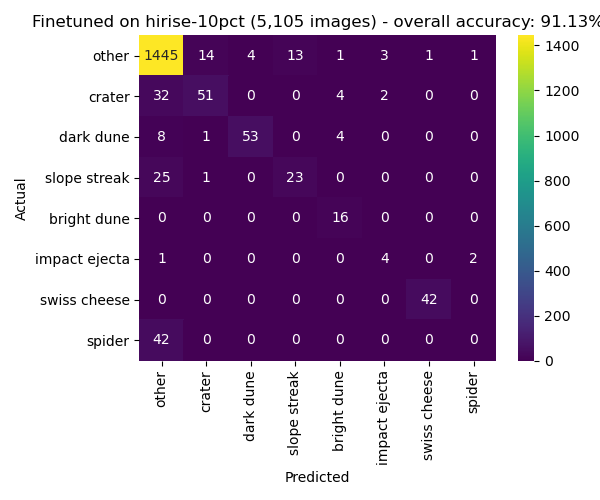

<IPython.core.display.Javascript object>


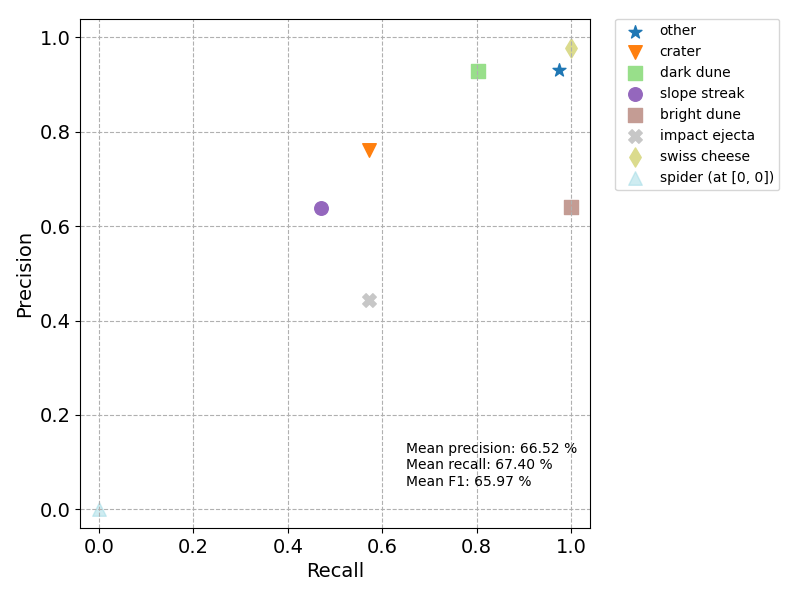

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-20
 acc = 91.13
 mean_precision = 66.52
mean_recall = 67.40

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-21
Performing eval at step 0
{'eval/supervised_loss': 0.5860089, 'eval/label_top_1_accuracy': 0.90853316, 'eval/label_top_5_accuracy': 0.9910764, 'global_step': 0}


<IPython.core.display.Javascript object>


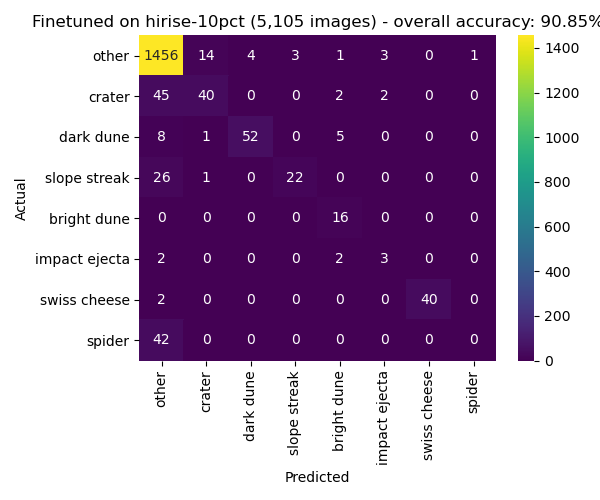

<IPython.core.display.Javascript object>


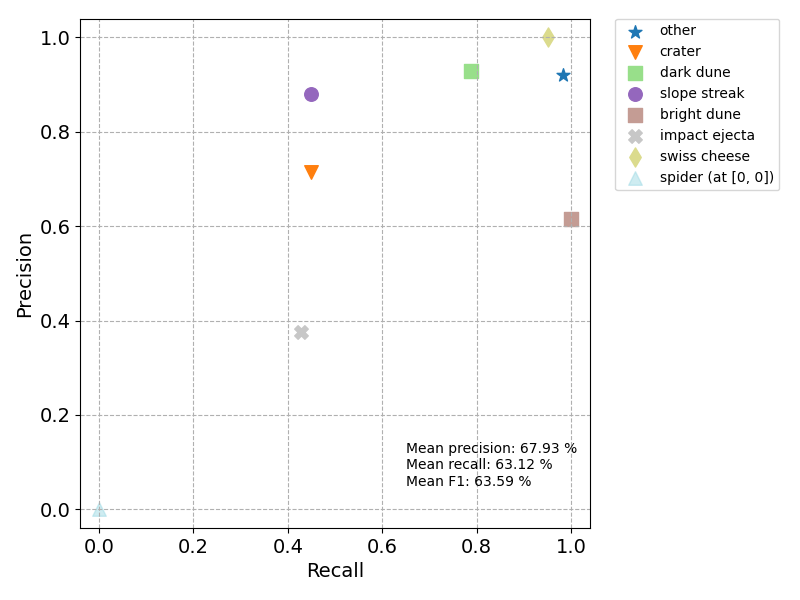

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-21
 acc = 90.85
 mean_precision = 67.93
mean_recall = 63.12

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-22
Performing eval at step 0
{'eval/supervised_loss': 0.6066343, 'eval/label_top_1_accuracy': 0.90964866, 'eval/label_top_5_accuracy': 0.99163413, 'global_step': 0}


<IPython.core.display.Javascript object>


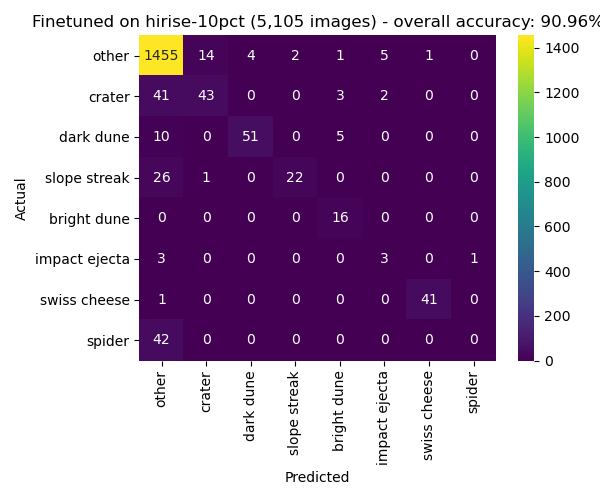

<IPython.core.display.Javascript object>


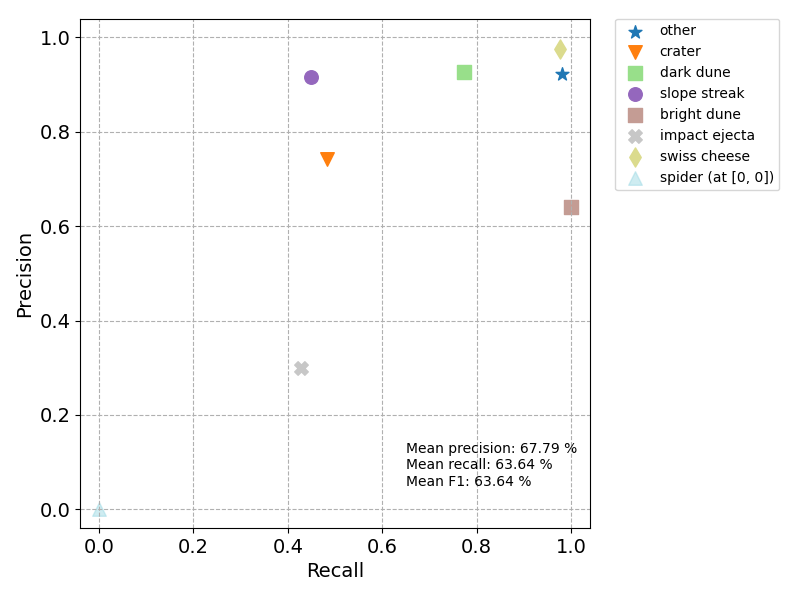

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-22
 acc = 90.96
 mean_precision = 67.79
mean_recall = 63.64

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-23
Performing eval at step 0
{'eval/supervised_loss': 0.6218399, 'eval/label_top_1_accuracy': 0.9102064, 'eval/label_top_5_accuracy': 0.98940325, 'global_step': 0}


<IPython.core.display.Javascript object>


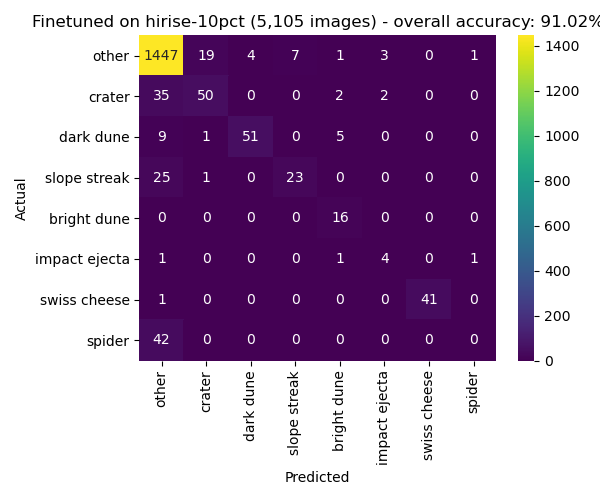

<IPython.core.display.Javascript object>


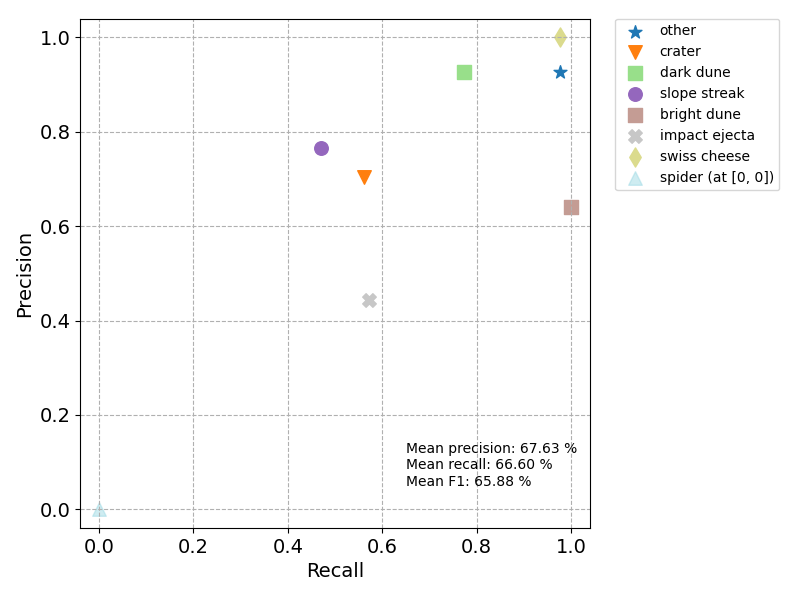

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-23
 acc = 91.02
 mean_precision = 67.63
mean_recall = 66.60

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-24
Performing eval at step 0
{'eval/supervised_loss': 0.6531599, 'eval/label_top_1_accuracy': 0.90797544, 'eval/label_top_5_accuracy': 0.9888455, 'global_step': 0}


<IPython.core.display.Javascript object>


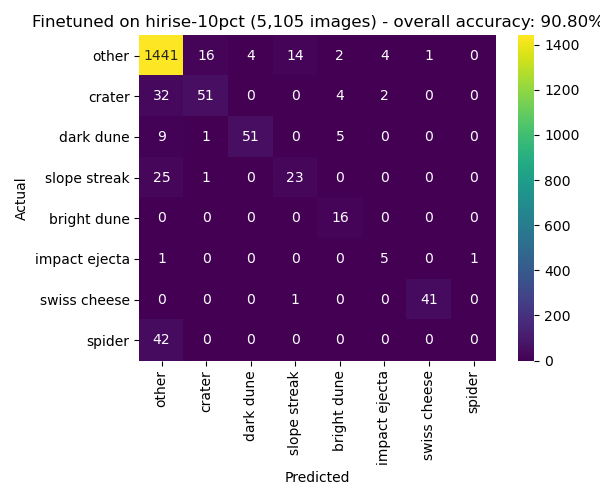

<IPython.core.display.Javascript object>


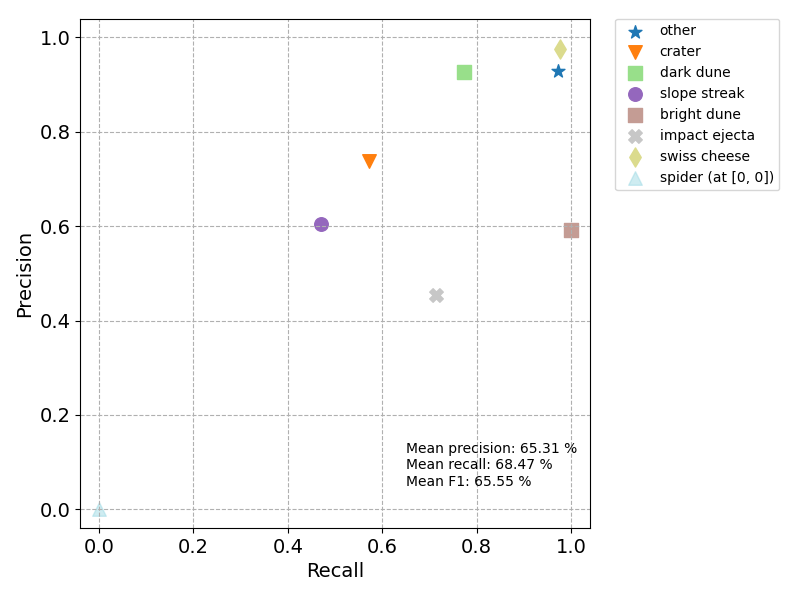

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-24
 acc = 90.80
 mean_precision = 65.31
mean_recall = 68.47

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-25
Performing eval at step 0
{'eval/supervised_loss': 0.63495094, 'eval/label_top_1_accuracy': 0.91243726, 'eval/label_top_5_accuracy': 0.98996097, 'global_step': 0}


<IPython.core.display.Javascript object>


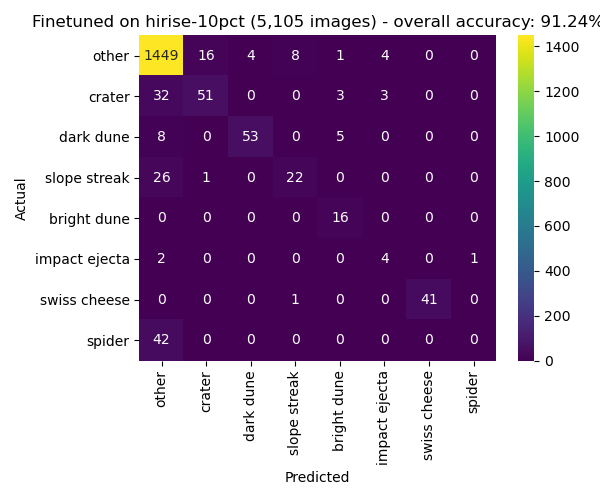

<IPython.core.display.Javascript object>


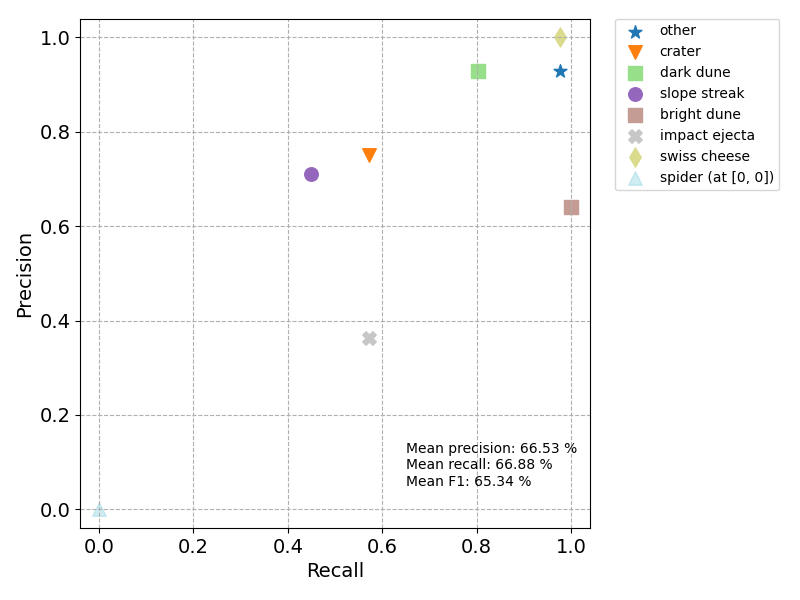

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-25
 acc = 91.24
 mean_precision = 66.53
mean_recall = 66.88

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-26
Performing eval at step 0
{'eval/supervised_loss': 0.71605474, 'eval/label_top_1_accuracy': 0.9141104, 'eval/label_top_5_accuracy': 0.9927496, 'global_step': 0}


<IPython.core.display.Javascript object>


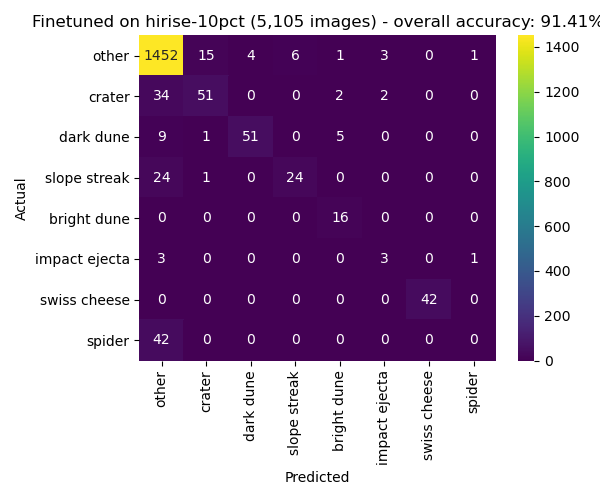

<IPython.core.display.Javascript object>


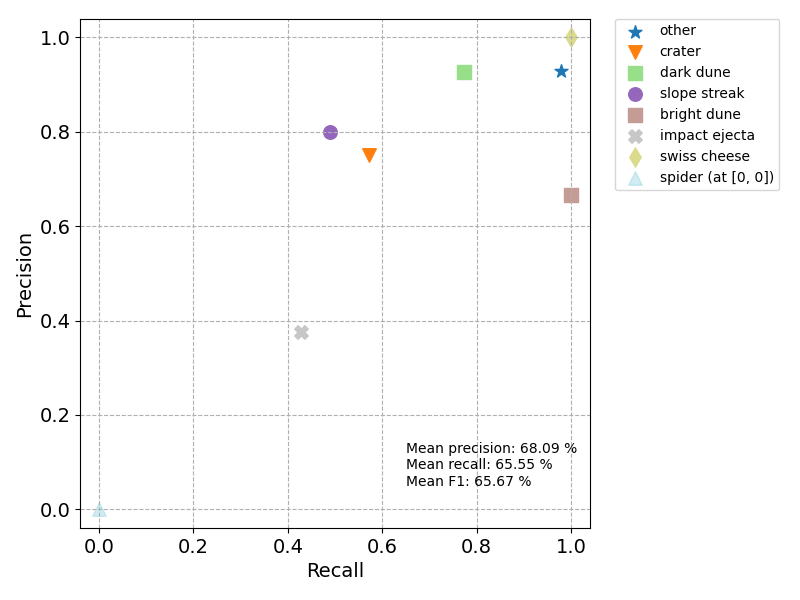

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-26
 acc = 91.41
 mean_precision = 68.09
mean_recall = 65.55

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-27
Performing eval at step 0
{'eval/supervised_loss': 0.7081675, 'eval/label_top_1_accuracy': 0.9141104, 'eval/label_top_5_accuracy': 0.9910764, 'global_step': 0}


<ipython-input-6-93f3a1baa888>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6, 5))


<IPython.core.display.Javascript object>


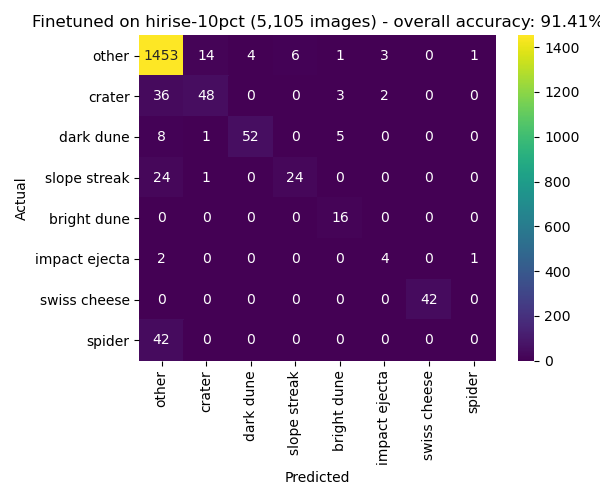

<IPython.core.display.Javascript object>


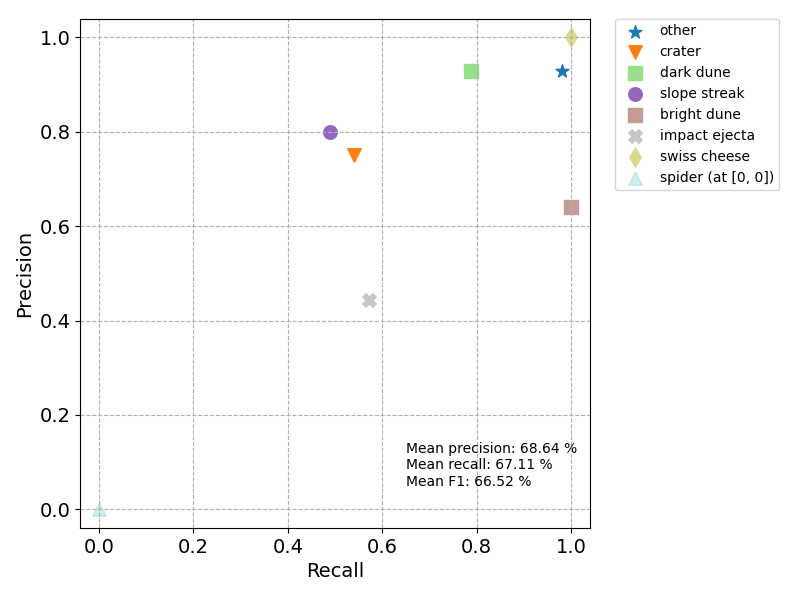

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-27
 acc = 91.41
 mean_precision = 68.64
mean_recall = 67.11

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-28
Performing eval at step 0
{'eval/supervised_loss': 0.7178477, 'eval/label_top_1_accuracy': 0.9163413, 'eval/label_top_5_accuracy': 0.98940325, 'global_step': 0}


<IPython.core.display.Javascript object>


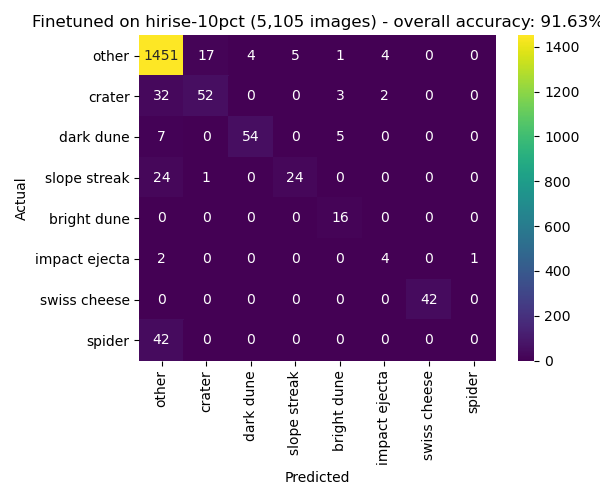

<IPython.core.display.Javascript object>


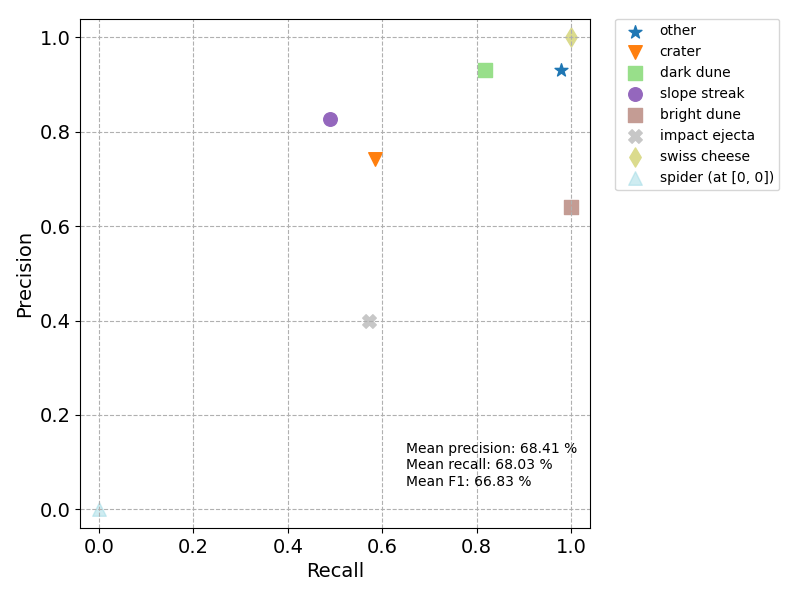

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-28
 acc = 91.63
 mean_precision = 68.41
mean_recall = 68.03

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-29
Performing eval at step 0
{'eval/supervised_loss': 0.7887988, 'eval/label_top_1_accuracy': 0.9107641, 'eval/label_top_5_accuracy': 0.9877301, 'global_step': 0}


<IPython.core.display.Javascript object>


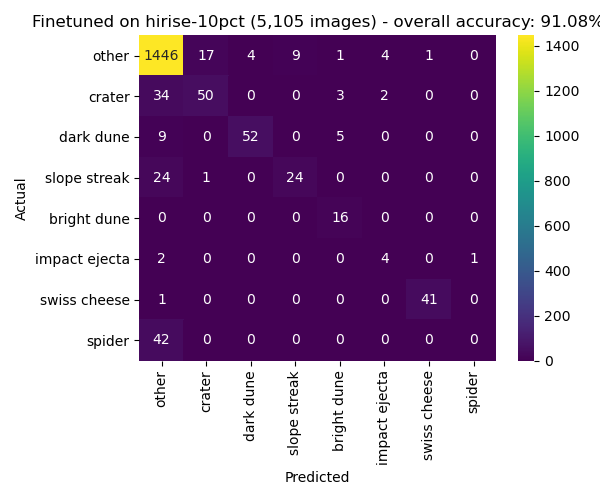

<IPython.core.display.Javascript object>


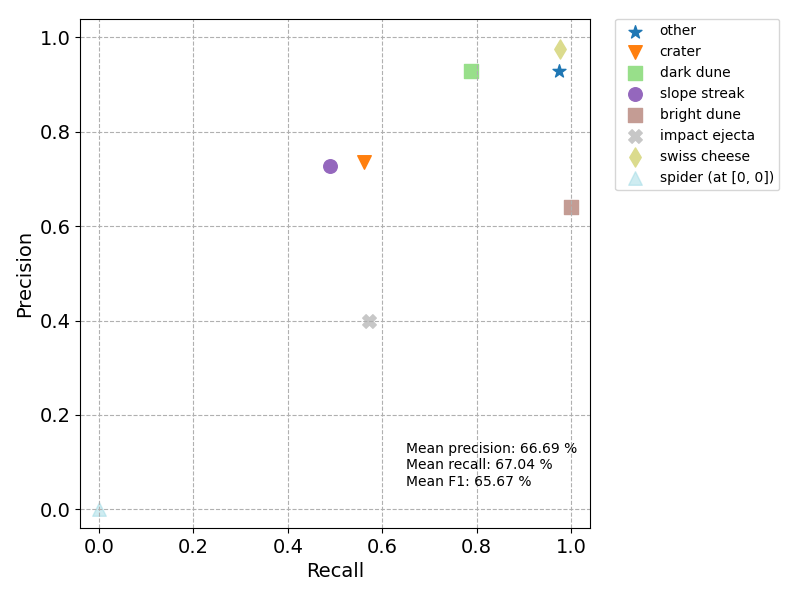

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-29
 acc = 91.08
 mean_precision = 66.69
mean_recall = 67.04

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-30
Performing eval at step 0
{'eval/supervised_loss': 0.83771026, 'eval/label_top_1_accuracy': 0.90964866, 'eval/label_top_5_accuracy': 0.9866146, 'global_step': 0}


<IPython.core.display.Javascript object>


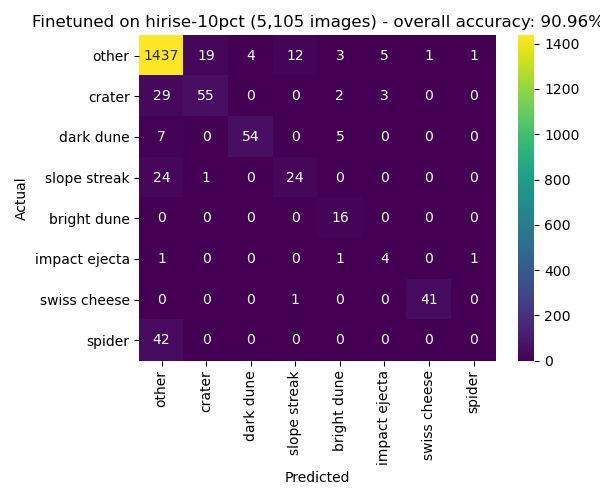

<IPython.core.display.Javascript object>


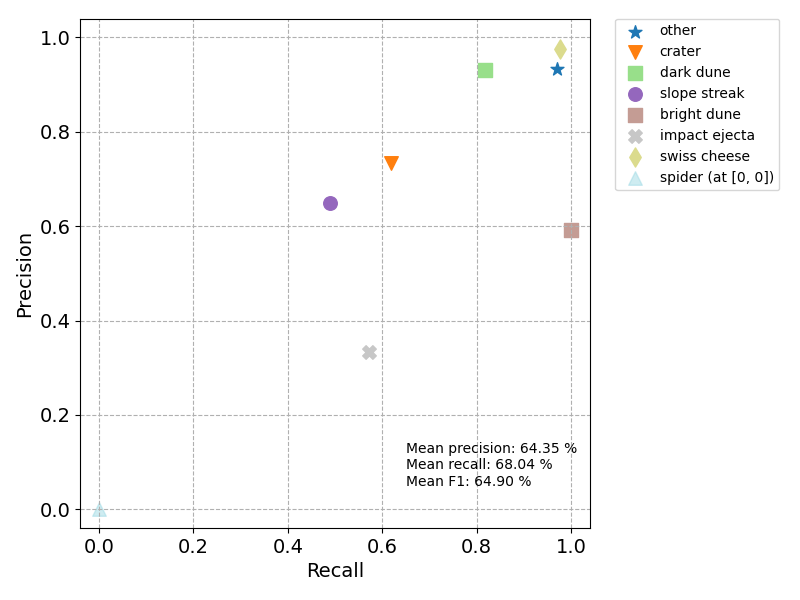

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-30
 acc = 90.96
 mean_precision = 64.35
mean_recall = 68.04

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-31
Performing eval at step 0
{'eval/supervised_loss': 0.8959816, 'eval/label_top_1_accuracy': 0.90909094, 'eval/label_top_5_accuracy': 0.9888455, 'global_step': 0}


<IPython.core.display.Javascript object>


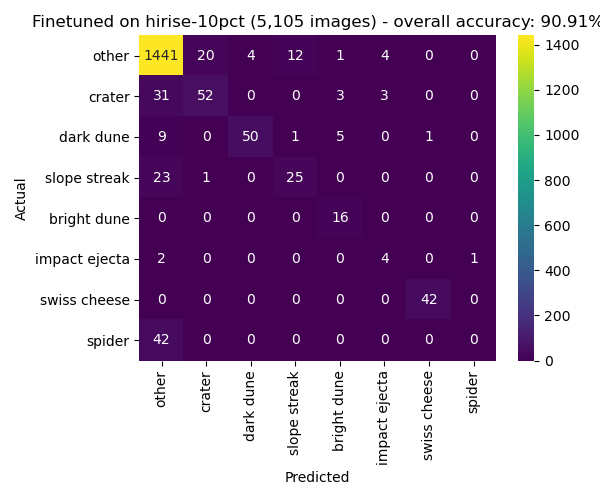

<IPython.core.display.Javascript object>


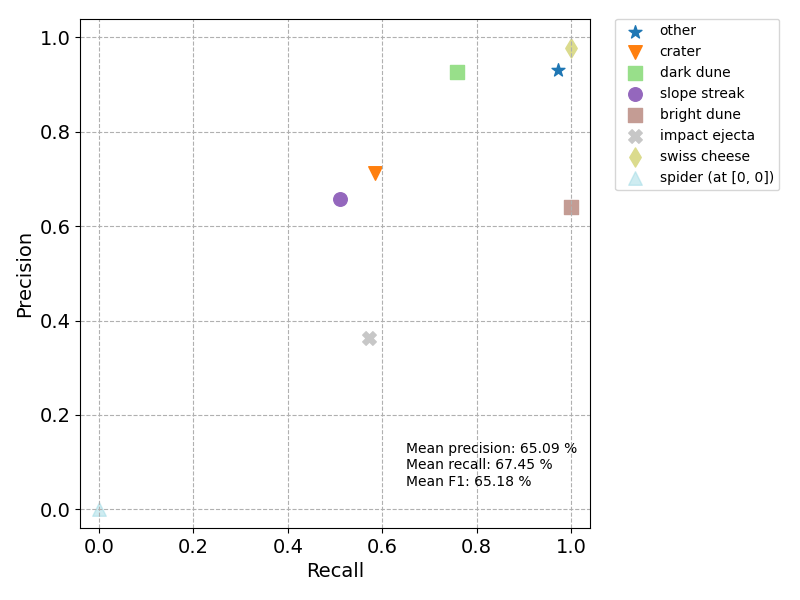

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-31
 acc = 90.91
 mean_precision = 65.09
mean_recall = 67.45

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-32
Performing eval at step 0
{'eval/supervised_loss': 0.8664542, 'eval/label_top_1_accuracy': 0.91466814, 'eval/label_top_5_accuracy': 0.9882878, 'global_step': 0}


<IPython.core.display.Javascript object>


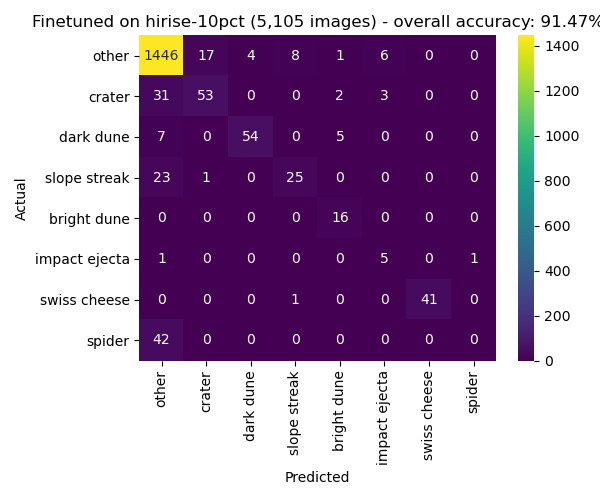

<IPython.core.display.Javascript object>


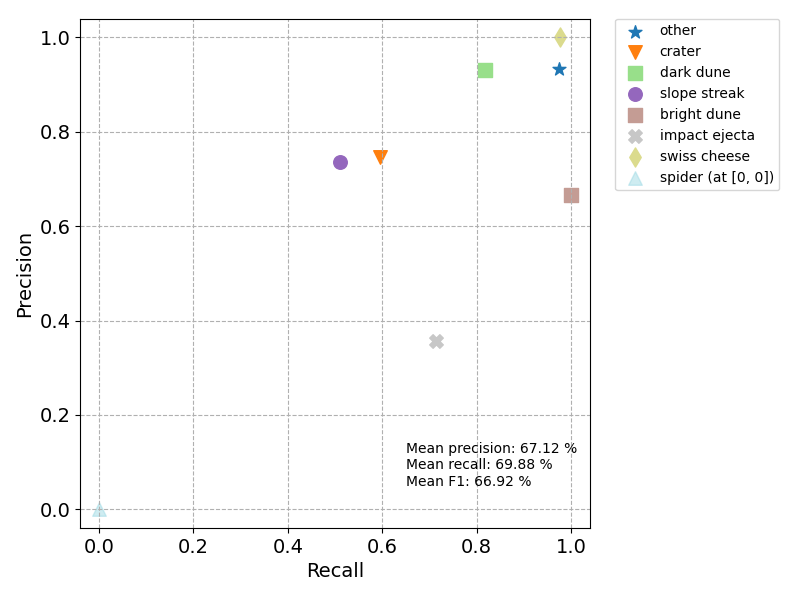

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-32
 acc = 91.47
 mean_precision = 67.12
mean_recall = 69.88

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-33
Performing eval at step 0
{'eval/supervised_loss': 0.9627448, 'eval/label_top_1_accuracy': 0.90351367, 'eval/label_top_5_accuracy': 0.9843837, 'global_step': 0}


<IPython.core.display.Javascript object>


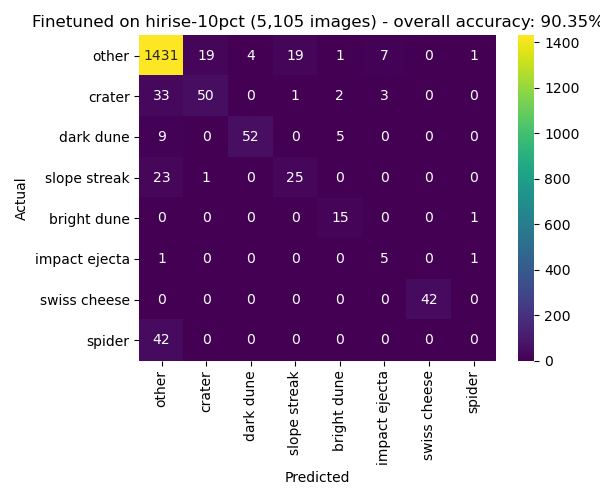

<IPython.core.display.Javascript object>


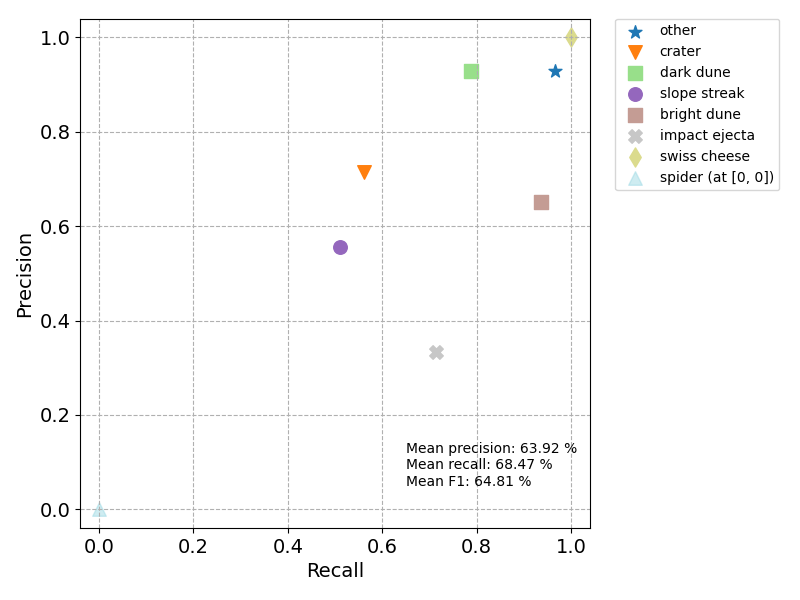

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-33
 acc = 90.35
 mean_precision = 63.92
mean_recall = 68.47

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-34
Performing eval at step 0
{'eval/supervised_loss': 0.9229344, 'eval/label_top_1_accuracy': 0.9174568, 'eval/label_top_5_accuracy': 0.9877301, 'global_step': 0}


<IPython.core.display.Javascript object>


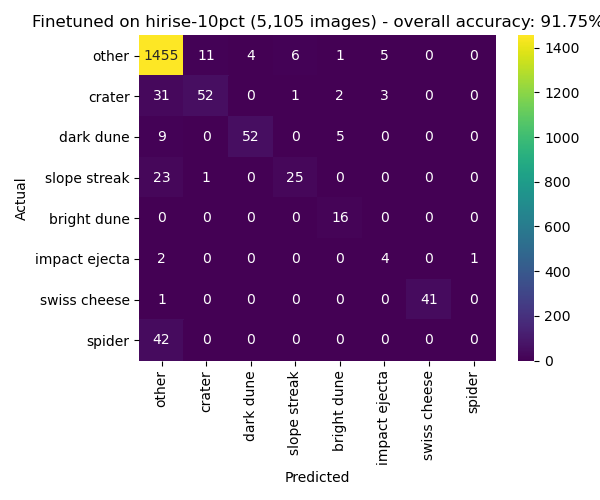

<IPython.core.display.Javascript object>


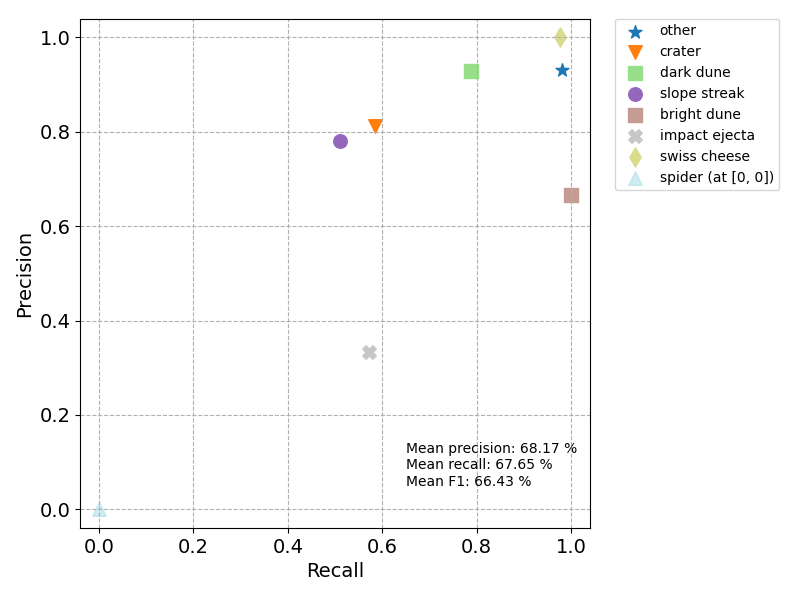

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-34
 acc = 91.75
 mean_precision = 68.17
mean_recall = 67.65

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-35
Performing eval at step 0
{'eval/supervised_loss': 0.95234525, 'eval/label_top_1_accuracy': 0.9163413, 'eval/label_top_5_accuracy': 0.9866146, 'global_step': 0}


<IPython.core.display.Javascript object>


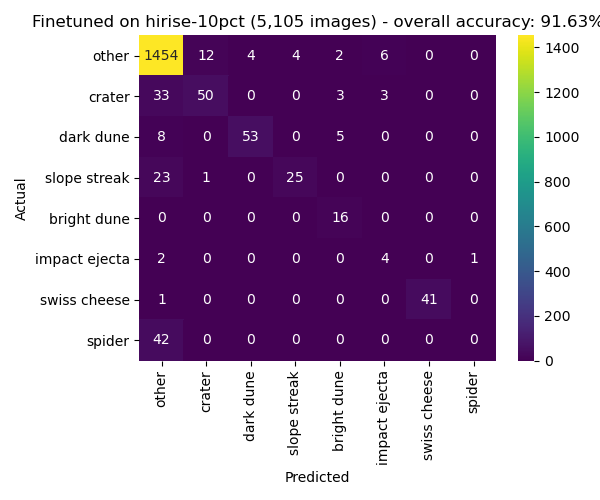

<IPython.core.display.Javascript object>


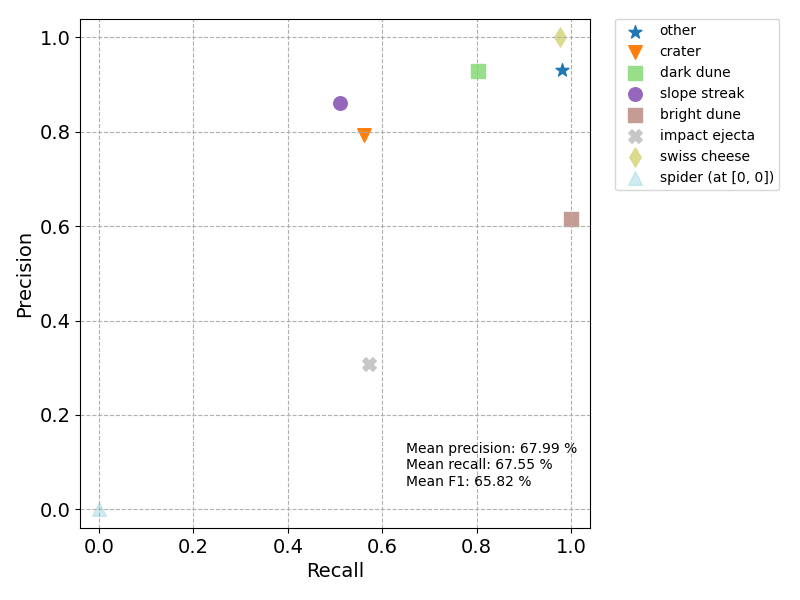

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-35
 acc = 91.63
 mean_precision = 67.99
mean_recall = 67.55

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-36
Performing eval at step 0
{'eval/supervised_loss': 0.99065125, 'eval/label_top_1_accuracy': 0.9180145, 'eval/label_top_5_accuracy': 0.9888455, 'global_step': 0}


<IPython.core.display.Javascript object>


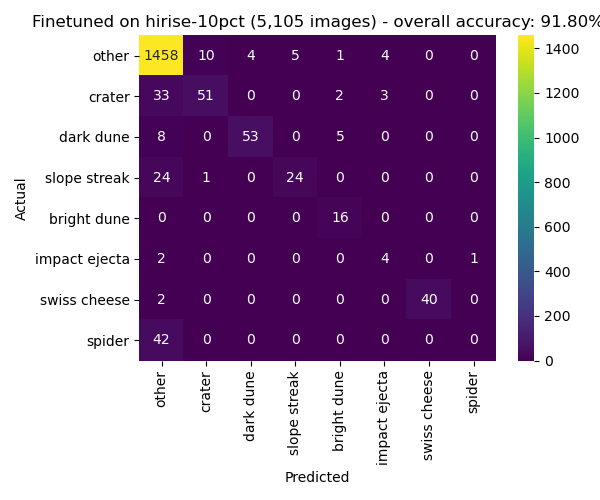

<IPython.core.display.Javascript object>


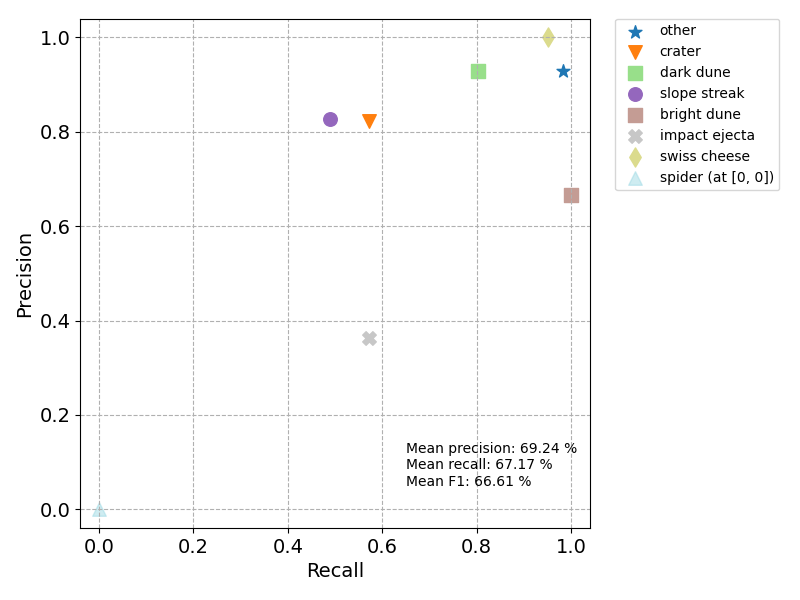

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-36
 acc = 91.80
 mean_precision = 69.24
mean_recall = 67.17

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-37
Performing eval at step 0
{'eval/supervised_loss': 1.0468998, 'eval/label_top_1_accuracy': 0.912995, 'eval/label_top_5_accuracy': 0.9877301, 'global_step': 0}


<IPython.core.display.Javascript object>


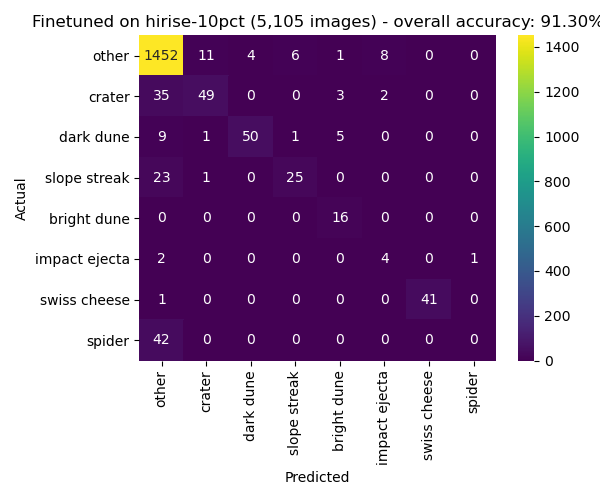

<IPython.core.display.Javascript object>


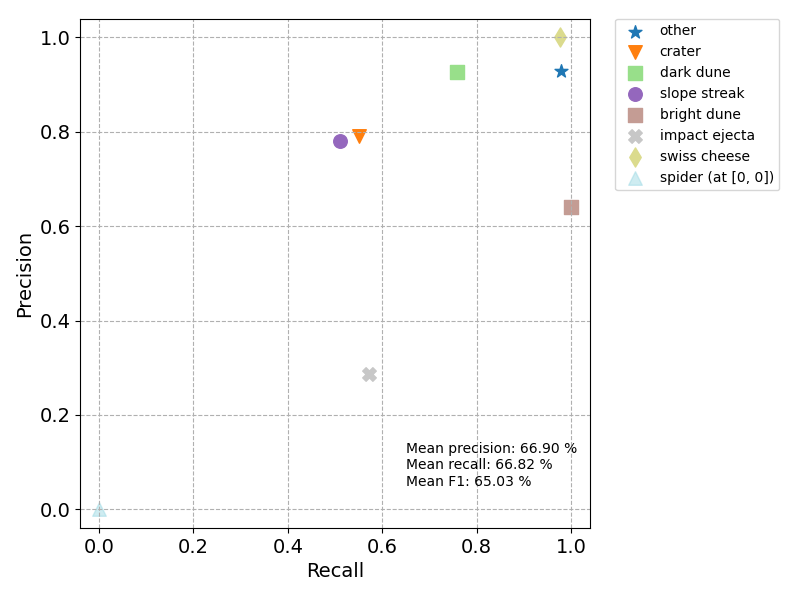

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-37
 acc = 91.30
 mean_precision = 66.90
mean_recall = 66.82

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-38
Performing eval at step 0
{'eval/supervised_loss': 1.0446417, 'eval/label_top_1_accuracy': 0.9107641, 'eval/label_top_5_accuracy': 0.98549914, 'global_step': 0}


<IPython.core.display.Javascript object>


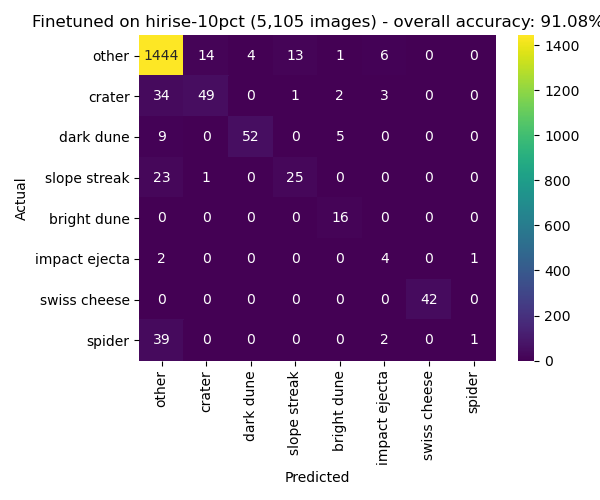

<IPython.core.display.Javascript object>


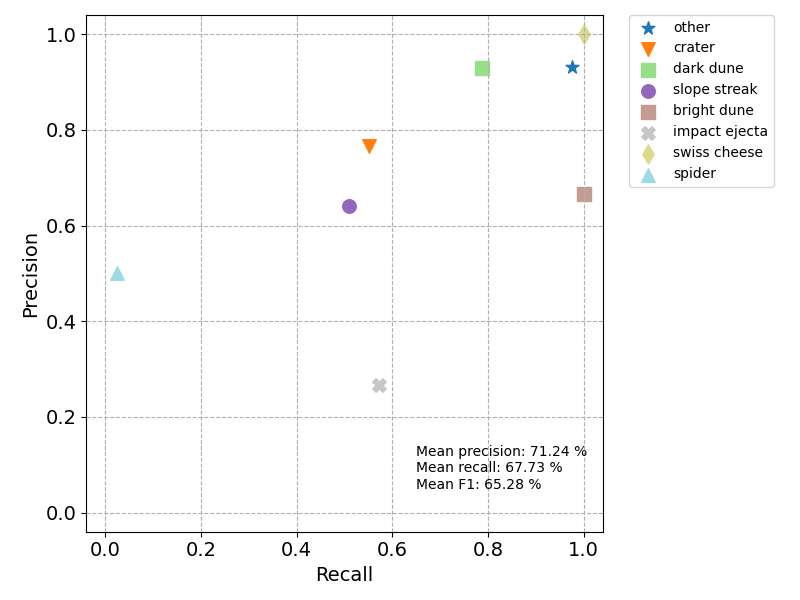

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-38
 acc = 91.08
 mean_precision = 71.24
mean_recall = 67.73

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-39
Performing eval at step 0
{'eval/supervised_loss': 1.1276861, 'eval/label_top_1_accuracy': 0.9102064, 'eval/label_top_5_accuracy': 0.9843837, 'global_step': 0}


<IPython.core.display.Javascript object>


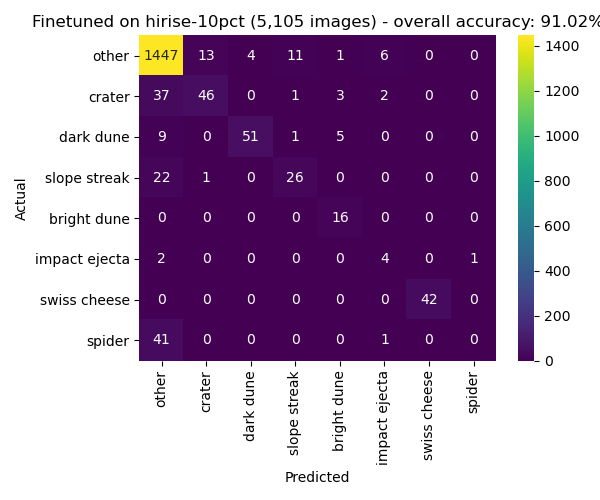

<IPython.core.display.Javascript object>


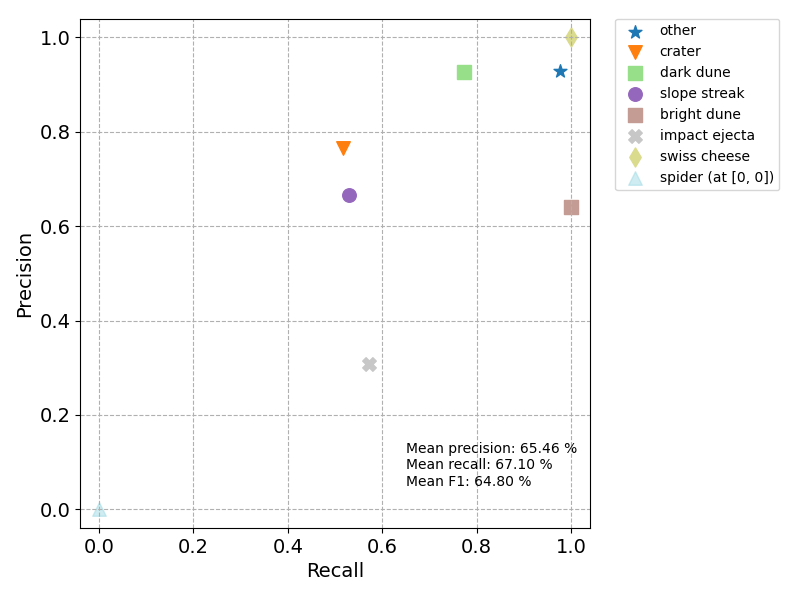

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-39
 acc = 91.02
 mean_precision = 65.46
mean_recall = 67.10

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-40
Performing eval at step 0
{'eval/supervised_loss': 1.150874, 'eval/label_top_1_accuracy': 0.9141104, 'eval/label_top_5_accuracy': 0.98605686, 'global_step': 0}


<IPython.core.display.Javascript object>


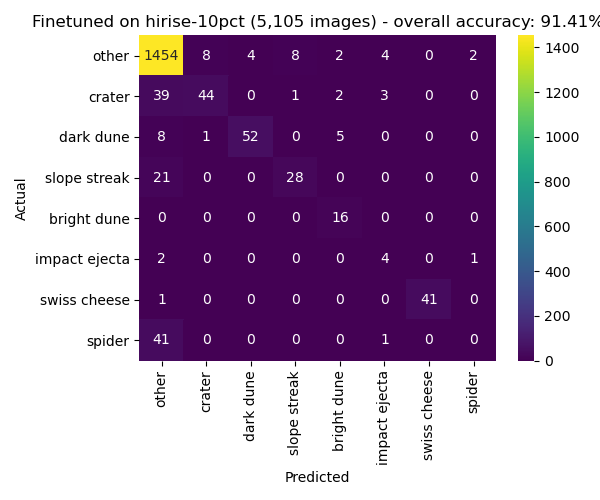

<IPython.core.display.Javascript object>


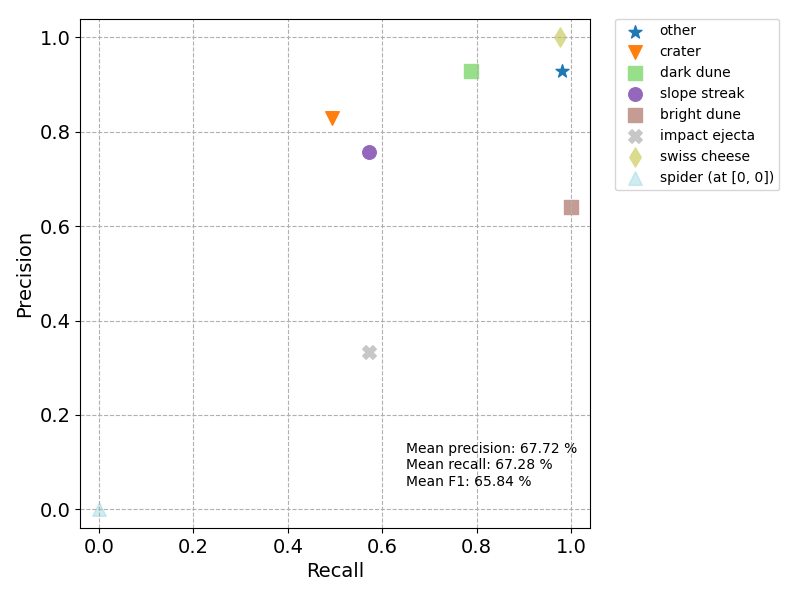

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-40
 acc = 91.41
 mean_precision = 67.72
mean_recall = 67.28

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-41
Performing eval at step 0
{'eval/supervised_loss': 1.084374, 'eval/label_top_1_accuracy': 0.91912997, 'eval/label_top_5_accuracy': 0.98549914, 'global_step': 0}


<IPython.core.display.Javascript object>


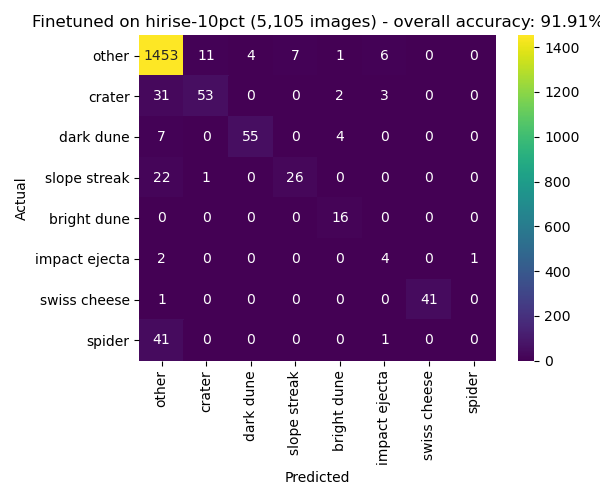

<IPython.core.display.Javascript object>


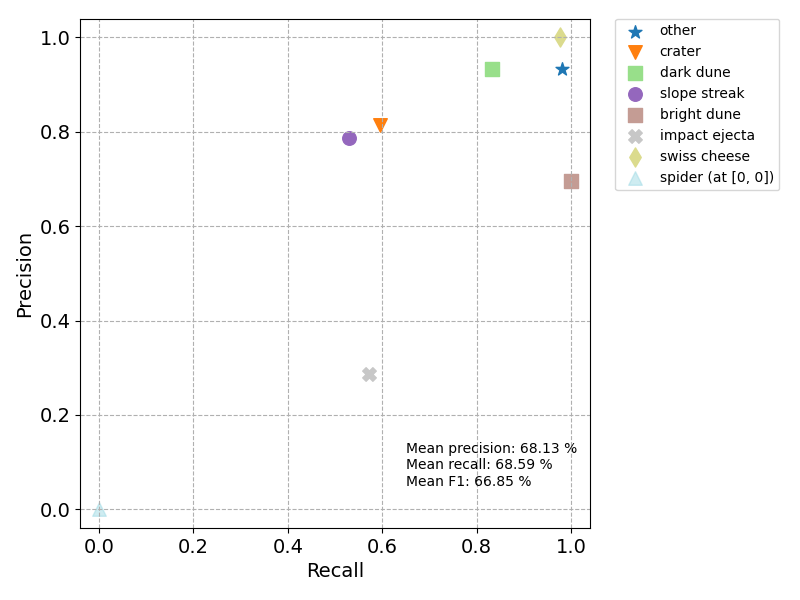

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-41
 acc = 91.91
 mean_precision = 68.13
mean_recall = 68.59

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-42
Performing eval at step 0
{'eval/supervised_loss': 1.1732119, 'eval/label_top_1_accuracy': 0.90853316, 'eval/label_top_5_accuracy': 0.9849414, 'global_step': 0}


<IPython.core.display.Javascript object>


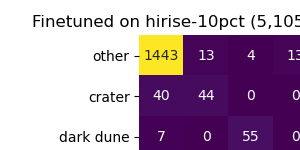

<IPython.core.display.Javascript object>


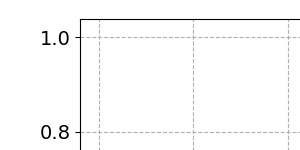

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-42
 acc = 90.85
 mean_precision = 65.36
mean_recall = 67.25

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-43
Performing eval at step 0
{'eval/supervised_loss': 1.1989083, 'eval/label_top_1_accuracy': 0.9157836, 'eval/label_top_5_accuracy': 0.983826, 'global_step': 0}


<IPython.core.display.Javascript object>


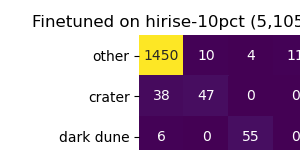

<IPython.core.display.Javascript object>


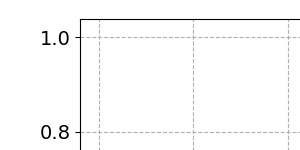

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-43
 acc = 91.58
 mean_precision = 67.32
mean_recall = 68.53

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-44
Performing eval at step 0
{'eval/supervised_loss': 1.2548141, 'eval/label_top_1_accuracy': 0.9141104, 'eval/label_top_5_accuracy': 0.98549914, 'global_step': 0}


<IPython.core.display.Javascript object>


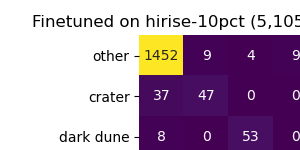

<IPython.core.display.Javascript object>


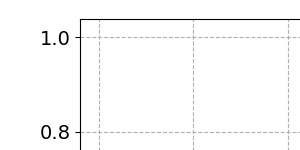

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-44
 acc = 91.41
 mean_precision = 66.91
mean_recall = 66.84

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-45
Performing eval at step 0
{'eval/supervised_loss': 1.290455, 'eval/label_top_1_accuracy': 0.91466814, 'eval/label_top_5_accuracy': 0.98549914, 'global_step': 0}


<IPython.core.display.Javascript object>


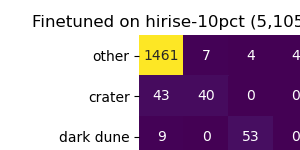

<IPython.core.display.Javascript object>


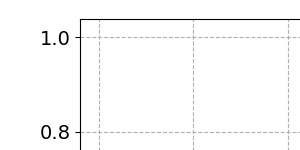

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-45
 acc = 91.47
 mean_precision = 68.55
mean_recall = 64.71

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-46
Performing eval at step 0
{'eval/supervised_loss': 1.2812444, 'eval/label_top_1_accuracy': 0.9135527, 'eval/label_top_5_accuracy': 0.9843837, 'global_step': 0}


<IPython.core.display.Javascript object>


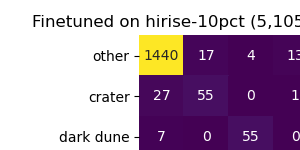

<IPython.core.display.Javascript object>


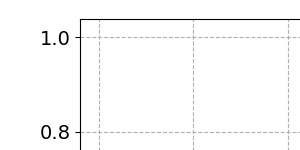

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-46
 acc = 91.36
 mean_precision = 65.01
mean_recall = 69.02

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-47
Performing eval at step 0
{'eval/supervised_loss': 1.2101239, 'eval/label_top_1_accuracy': 0.91466814, 'eval/label_top_5_accuracy': 0.98940325, 'global_step': 0}


<IPython.core.display.Javascript object>


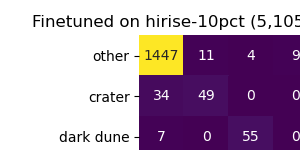

<IPython.core.display.Javascript object>


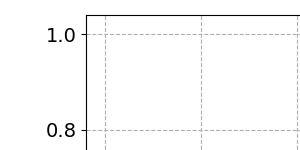

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-47
 acc = 91.47
 mean_precision = 71.70
mean_recall = 68.53

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-48
Performing eval at step 0
{'eval/supervised_loss': 1.2595268, 'eval/label_top_1_accuracy': 0.91466814, 'eval/label_top_5_accuracy': 0.9849414, 'global_step': 0}


<IPython.core.display.Javascript object>


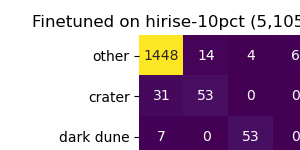

<IPython.core.display.Javascript object>


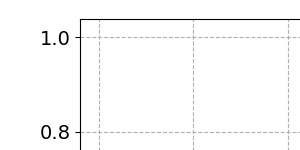

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-48
 acc = 91.47
 mean_precision = 66.39
mean_recall = 67.39

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-49
Performing eval at step 0
{'eval/supervised_loss': 1.3796996, 'eval/label_top_1_accuracy': 0.91466814, 'eval/label_top_5_accuracy': 0.98717237, 'global_step': 0}


<IPython.core.display.Javascript object>


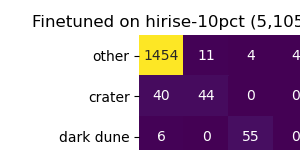

<IPython.core.display.Javascript object>


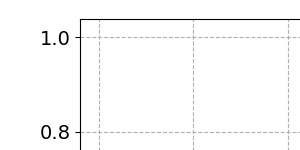

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-49
 acc = 91.47
 mean_precision = 68.06
mean_recall = 67.38

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-50
Performing eval at step 0
{'eval/supervised_loss': 1.5792067, 'eval/label_top_1_accuracy': 0.90797544, 'eval/label_top_5_accuracy': 0.9866146, 'global_step': 0}


<IPython.core.display.Javascript object>


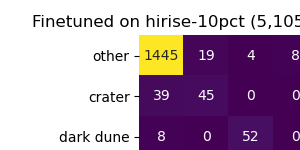

<IPython.core.display.Javascript object>


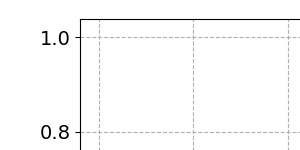

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-50
 acc = 90.80
 mean_precision = 65.91
mean_recall = 66.58

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-51
Performing eval at step 0
{'eval/supervised_loss': 1.3694937, 'eval/label_top_1_accuracy': 0.9174568, 'eval/label_top_5_accuracy': 0.983826, 'global_step': 0}


<IPython.core.display.Javascript object>


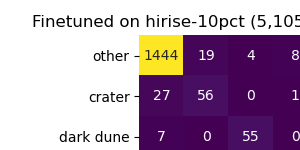

<IPython.core.display.Javascript object>


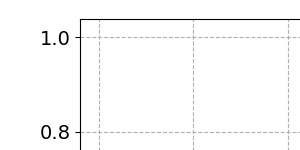

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-51
 acc = 91.75
 mean_precision = 67.40
mean_recall = 71.24

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-52
Performing eval at step 0
{'eval/supervised_loss': 1.4484143, 'eval/label_top_1_accuracy': 0.91522586, 'eval/label_top_5_accuracy': 0.9849414, 'global_step': 0}


<IPython.core.display.Javascript object>


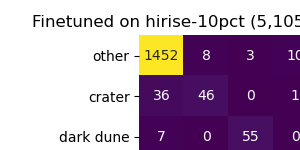

<IPython.core.display.Javascript object>


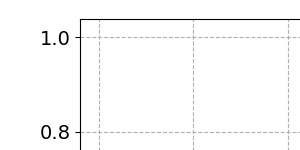

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-52
 acc = 91.52
 mean_precision = 66.96
mean_recall = 67.86

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-53
Performing eval at step 0
{'eval/supervised_loss': 1.5686142, 'eval/label_top_1_accuracy': 0.90351367, 'eval/label_top_5_accuracy': 0.97992194, 'global_step': 0}


<IPython.core.display.Javascript object>


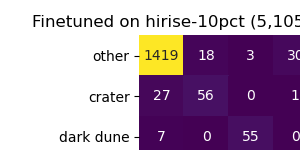

<IPython.core.display.Javascript object>


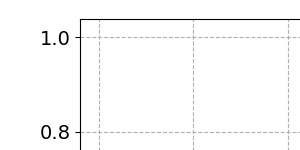

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-53
 acc = 90.35
 mean_precision = 63.50
mean_recall = 69.49

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-54
Performing eval at step 0
{'eval/supervised_loss': 1.4983529, 'eval/label_top_1_accuracy': 0.91522586, 'eval/label_top_5_accuracy': 0.983826, 'global_step': 0}


<IPython.core.display.Javascript object>


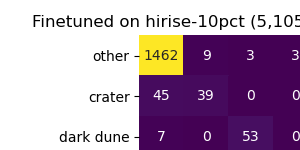

<IPython.core.display.Javascript object>


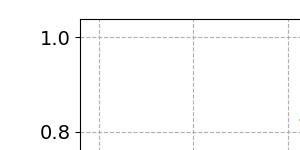

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-54
 acc = 91.52
 mean_precision = 69.26
mean_recall = 66.37

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-55
Performing eval at step 0
{'eval/supervised_loss': 1.5024468, 'eval/label_top_1_accuracy': 0.9174568, 'eval/label_top_5_accuracy': 0.98047966, 'global_step': 0}


<IPython.core.display.Javascript object>


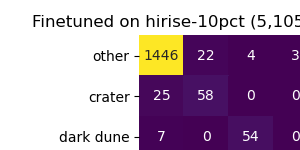

<IPython.core.display.Javascript object>


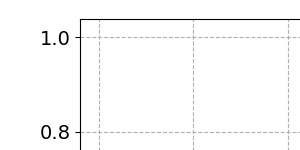

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-55
 acc = 91.75
 mean_precision = 68.17
mean_recall = 70.58

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-56
Performing eval at step 0
{'eval/supervised_loss': 1.5100535, 'eval/label_top_1_accuracy': 0.91912997, 'eval/label_top_5_accuracy': 0.9788065, 'global_step': 0}


<IPython.core.display.Javascript object>


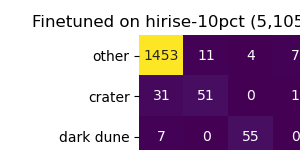

<IPython.core.display.Javascript object>


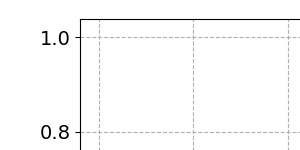

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_hirise-10pct_r50_2x_sk1_proj128_3projLayers_2021-08-10_0943/ckpt-56
 acc = 91.91
 mean_precision = 68.83
mean_recall = 70.40



In [8]:
logdir = os.path.join('/home/goh/Documents/tensorboard', log_name, 'eval')


outputs = []
for n in range(17,57):  # remember to change this to match ckpt nums
    ckpt = os.path.join(model_dir, f'ckpt-{n}')
    with tf.device('/gpu:7'):
        logits, predictions, labels = perform_evaluation(model, test_ds, num_classes, ckpt, logdir, strategy=None, eval_steps=1, batch_size=64)
    
    # plot results
    y_true = [classes[l] for l in labels]
    y_pred = [classes[p] for p in predictions]
    fig1, ax1, cm, acc = plot_confusion_matrix(y_true, y_pred, ckpt)
    fig2, ax2, cr_df, prec, recall = plot_precision_vs_recall(y_true, y_pred, ckpt)

    ax1.set_title(f"Finetuned on {dataset} (5,105 images) - overall accuracy: {100*acc:.2f}%")    
    
    outputs.append((ckpt, acc, cm, cr_df, prec, recall))
    print(
        f"ckpt = {ckpt}\n",
        f"acc = {100*acc:.2f}\n",
        f"mean_precision = {100 * prec:.2f}\n"
        f"mean_recall = {100 * recall:.2f}\n"
    )


In [9]:
res_df = pd.DataFrame.from_records(
    [(o[0].split('/')[-1], o[1], o[4], o[5]) for o in outputs],
    columns=['ckpt', 'acc', 'prec', 'recall']
).sort_values(by='recall', ascending=False)

res_df.to_csv(os.path.join(model_dir, "results.csv"))

res_df

ckpt       acc      prec    recall
34  ckpt-51  0.917457  0.673980  0.712351
38  ckpt-55  0.917457  0.681658  0.705782
39  ckpt-56  0.919130  0.688261  0.703962
15  ckpt-32  0.914668  0.671190  0.698760
36  ckpt-53  0.903514  0.634955  0.694937
29  ckpt-46  0.913553  0.650118  0.690201
24  ckpt-41  0.919130  0.681255  0.685938
30  ckpt-47  0.914668  0.717036  0.685341
26  ckpt-43  0.915784  0.673185  0.685336
7   ckpt-24  0.907975  0.653084  0.684745
16  ckpt-33  0.903514  0.639218  0.684657
13  ckpt-30  0.909649  0.643531  0.680401
11  ckpt-28  0.916341  0.684100  0.680345
35  ckpt-52  0.915226  0.669567  0.678573
21  ckpt-38  0.910764  0.712446  0.677280
17  ckpt-34  0.917457  0.681653  0.676469
2   ckpt-19  0.914110  0.681971  0.675731
18  ckpt-35  0.916341  0.679860  0.675470
14  ckpt-31  0.909091  0.650926  0.674477
3   ckpt-20  0.911322  0.665194  0.673989
31  ckpt-48  0.914668  0.663942  0.673916
32  ckpt-49  0.914668  0.680570  0.673807
23  ckpt-40  0.914110  0.677166  0.672802
25  ckpt-42  0.908533  0.653641  0.672454
19  ckpt-36  0.918015  0.692444  0.671684
10  ckpt-27  0.914110  0.686431  0.671108
22  ckpt-39  0.910206  0.654632  0.671001
12  ckpt-29  0.910764  0.666930  0.670350
8   ckpt-25  0.912437  0.665323  0.668799
27  ckpt-44  0.914110  0.669137  0.668377
20  ckpt-37  0.912995  0.668950  0.668215
6   ckpt-23  0.910206  0.676272  0.665989
33  ckpt-50  0.907975  0.659139  0.665794
1   ckpt-18  0.912437  0.679527  0.663944
37  ckpt-54  0.915226  0.692573  0.663671
0   ckpt-17  0.912437  0.676472  0.663029
9   ckpt-26  0.914110  0.680916  0.655486
28  ckpt-45  0.914668  0.685465  0.647134
5   ckpt-22  0.909649  0.677945  0.636425
4   ckpt-21  0.908533  0.679272  0.631213

In [9]:
pd.DataFrame.from_records(
    [(o[0].split('/')[-1], o[1], o[4], o[5]) for o in outputs],
    columns=['ckpt', 'acc', 'prec', 'recall']
).sort_values(by='recall', ascending=False)

ckpt       acc      prec    recall
14  ckpt-169  0.556667  0.579164  0.573807
13  ckpt-168  0.535000  0.572226  0.567032
7   ckpt-162  0.546667  0.570333  0.563951
1   ckpt-156  0.560000  0.573856  0.563059
11  ckpt-166  0.520000  0.565205  0.561828
0   ckpt-155  0.555000  0.575086  0.558150
9   ckpt-164  0.545000  0.563364  0.557135
10  ckpt-165  0.538333  0.557652  0.555892
6   ckpt-161  0.536667  0.565783  0.551444
2   ckpt-157  0.545000  0.567828  0.548959
8   ckpt-163  0.541667  0.570024  0.546100
12  ckpt-167  0.540000  0.571909  0.545501
5   ckpt-160  0.531667  0.545796  0.540822
4   ckpt-159  0.538333  0.564779  0.540038
3   ckpt-158  0.548333  0.578550  0.537107